In [10]:
import datetime
import pytz


def is_during_trading_session(zone="Asia/Seoul") -> bool:
    tz = pytz.timezone(zone=zone)
    now = datetime.datetime.now(tz=tz)
    start_time = now.replace(hour=9, minute=00, second=0, microsecond=0)
    end_time = now.replace(hour=15, minute=30, second=0, microsecond=0)
    return start_time <= now <= end_time


is_during_trading_session()


True

[*********************100%***********************]  8 of 8 completed
simulate |██████████████████████████████████████████████████| 100.00% 2319.07
value    0.109888
value    0.184689
value    0.594991
dtype: float64


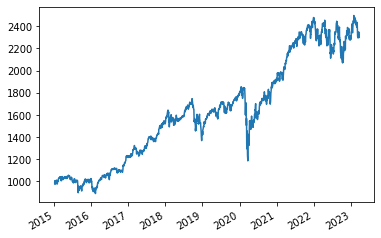

In [1]:
from src.core import strategy
from src.core import metrics
import yfinance as yf

prices = yf.download("XLU, XLK, XLB, XLP, XLY, XLI, XLV, XLF")["Adj Close"]

strategy = strategy.Momentum(prices).simulate(
    start="2015-1-1", min_volatility=0.12
)

strategy.value.plot()
print(strategy.analytics())
